# Cell type proportion

In [50]:
library(corrplot)
library(data.table)
library(planet)
library(minfi)
library(tidyverse)

corrplot 0.90 loaded



# NICHD (Delahaye) Cohort
## Load in processed methylation data

In [73]:
metadata <- fread("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/matrix_eqtl_data/mQTL_covar_10_methy_PC.txt")
varnames <-metadata$id
metadata <- t(metadata[,-c(1)]) %>% as.data.frame() %>% rownames_to_column("sample")
colnames(metadata)[-c(1)] <- varnames
head(metadata)
methy_data <- fread("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/matrix_eqtl_data/methylation_matrixeQTL.txt") %>% column_to_rownames(var="cpg")
head(methy_data)

,sample,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,batch,Gestational.Age.at.Delivery,V3,V4,V5,V6,V7,Sex
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8366,-3.766228,-4.515446,11.972721,-13.3628079,0.8464186,-2.2776877,3.0665119,-4.518609,4.044228,-1.5992651,0,273,-0.0455679,0.00126182,-0.09752270,-0.000882601,0.02813900,0
2,8367,11.514503,-5.260580,-11.746535,-2.2354826,4.6160358,-1.2016947,-0.3441745,-5.691857,-1.736797,-1.4305830,0,286,-0.0516306,-0.06654700,0.03945300,0.024553800,0.03229360,1
3,8368,6.943321,2.998059,-4.533553,6.5918547,4.4710100,-2.3214357,1.1309702,-4.651071,3.168937,-4.2902162,0,289,-0.0497718,0.08926320,0.06728400,-0.004247210,0.00526597,1
4,8369,8.257881,2.804045,-10.641456,-4.5456451,4.2280293,-0.2888692,1.3335097,-5.270167,-2.059196,-0.8610622,0,274,-0.0508578,-0.06675070,0.04304730,0.027215200,0.01179170,1
5,8370,-6.792578,-8.864319,-6.427358,0.8945467,6.8461817,-5.1170216,-6.3381810,-4.739155,-0.455603,-3.6892225,0,273,-0.0375988,-0.03726200,-0.00787066,0.021922500,0.01952150,0
6,8372,12.506517,-4.627762,-8.993498,-11.2194932,-2.2057630,4.1674553,-3.1444138,-5.800810,-5.965069,-8.3053828,0,259,-0.0504271,0.02704570,-0.01861770,-0.110494000,0.00919611,1


,8366,8367,8368,8369,8370,8372,8374,8394,8396,8399,⋯,TB8890,TB8891,TB8892,TB8899,TB8900,TB8901,TB8902,TB8903,TB8904,TB8905
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cg13869341,0.82244386,0.77509957,0.85085814,0.86362290,0.80990572,0.89037849,0.84351150,0.85863006,0.78999358,0.86791566,⋯,0.83166199,0.80445759,0.8347727,0.80779558,0.81215016,0.88594563,0.7866578,0.81245084,0.76972790,0.8534155
cg22802167,0.86305268,0.87590393,0.89379180,0.90245959,0.89818883,0.89290246,0.90413113,0.88501998,0.87200380,0.87934188,⋯,0.85167685,0.85181778,0.8694119,0.86872887,0.86102886,0.87446554,0.8562883,0.85243110,0.87430888,0.8429161
cg24669183,0.71155008,0.73411001,0.73815462,0.78030230,0.74761959,0.72038299,0.75249898,0.73720924,0.71811510,0.75334743,⋯,0.70269474,0.80811715,0.6620158,0.72377385,0.70485510,0.70858345,0.6950979,0.69684405,0.77603591,0.7833516
cg15560884,0.49876401,0.49179804,0.50093394,0.51986401,0.50224276,0.51697240,0.47123468,0.51680213,0.48654406,0.53919795,⋯,0.51115199,0.53424559,0.5058161,0.47264338,0.53836368,0.51974316,0.5613612,0.54786039,0.52862670,0.5243852
cg01014490,0.09025956,0.03037804,0.07425798,0.03878096,0.06597222,0.06135315,0.06147944,0.06439442,0.06466946,0.05368152,⋯,0.04010282,0.04745318,0.0526473,0.04490821,0.04391407,0.03685238,0.0265367,0.03365984,0.06397147,0.2097520
cg17505339,0.92662414,0.88627090,0.91178598,0.91970427,0.89618916,0.91180625,0.89862902,0.87781499,0.90248695,0.88944281,⋯,0.91087377,0.90257390,0.9175086,0.91513775,0.92022302,0.91429464,0.8926924,0.88470494,0.92331017,0.9163152


## Cell type estimation

In [74]:
data('plCellCpGsThird')
houseman_estimates <- minfi:::projectCellType(
  methy_data[rownames(plCellCpGsThird),], 
  plCellCpGsThird,
  lessThanOne = FALSE)
houseman_estimates %>% write.csv(file = "../data/houseman_placenta_cell_type_prop.csv",row.names = F, quote=F)

## Plot out proportions

sample,Sex,component,estimate
<fct>,<chr>,<chr>,<dbl>
8366,Female,Trophoblasts,2.856192e-19
8366,Female,Stromal,1.717034e-01
8366,Female,Hofbauer,0.000000e+00
8366,Female,Endothelial,1.121258e-01
8366,Female,nRBC,5.247168e-02
8366,Female,Syncytiotrophoblast,6.497603e-01


Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


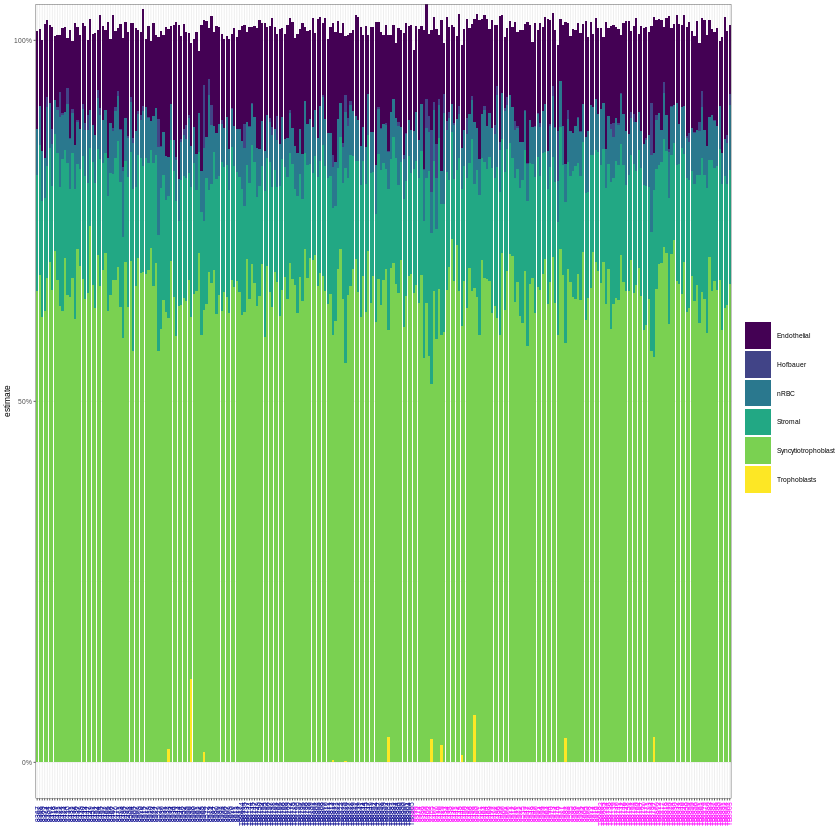

In [75]:
cell_type_df <- houseman_estimates  %>% as_tibble() %>% mutate(sample = colnames(methy_data),Sex = metadata$Sex) %>% 
            mutate(Sex = ifelse(Sex == 1, "Male","Female"))
                                                                 
plot_df <- cell_type_df %>% pivot_longer(cols = -c(sample,Sex),
             names_to = 'component',
             values_to = 'estimate') 
plot_df$sample <- factor(plot_df$sample, levels = c(unique(plot_df$sample[plot_df$Sex == "Male"]), unique(plot_df$sample[plot_df$Sex == "Female" ])))
head(plot_df)
color_map <- data.frame(sample = levels(plot_df$sample)) %>% mutate(color = ifelse(sample %in% cell_type_df$sample[cell_type_df$Sex == "Male"],"darkblue","magenta"))


  ggplot(plot_df, aes(x = sample, y = estimate, fill = component)) +
  geom_bar(stat = 'identity') +
  scale_fill_viridis_d() +
  theme_bw(base_size = 5) +
  scale_y_continuous(limits = c(-0.1,1.1), breaks = c(0, 0.5, 1), labels = scales::percent) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, color = color_map$color)) +
  coord_cartesian(ylim = c(0,1)) +
  labs(x = '', fill = '')

## Sex differences in proportions

component,.y.,group1,group2,p,p.adj,p.format,p.signif,method,y_pos
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Trophoblasts,estimate,Male,Female,0.31655511,1.000,0.3166,ns,Wilcoxon,1
Stromal,estimate,Male,Female,0.00544312,0.033,0.0054,**,Wilcoxon,1
Hofbauer,estimate,Male,Female,0.19134037,0.960,0.1913,ns,Wilcoxon,1
Endothelial,estimate,Male,Female,0.56153243,1.000,0.5615,ns,Wilcoxon,1
nRBC,estimate,Male,Female,0.31117571,1.000,0.3112,ns,Wilcoxon,1
Syncytiotrophoblast,estimate,Male,Female,0.40046297,1.000,0.4005,ns,Wilcoxon,1


sample,Sex,component,estimate
<chr>,<fct>,<chr>,<dbl>
8366,Female,Trophoblasts,2.856192e-19
8366,Female,Stromal,1.717034e-01
8366,Female,Hofbauer,0.000000e+00
8366,Female,Endothelial,1.121258e-01
8366,Female,nRBC,5.247168e-02
8366,Female,Syncytiotrophoblast,6.497603e-01


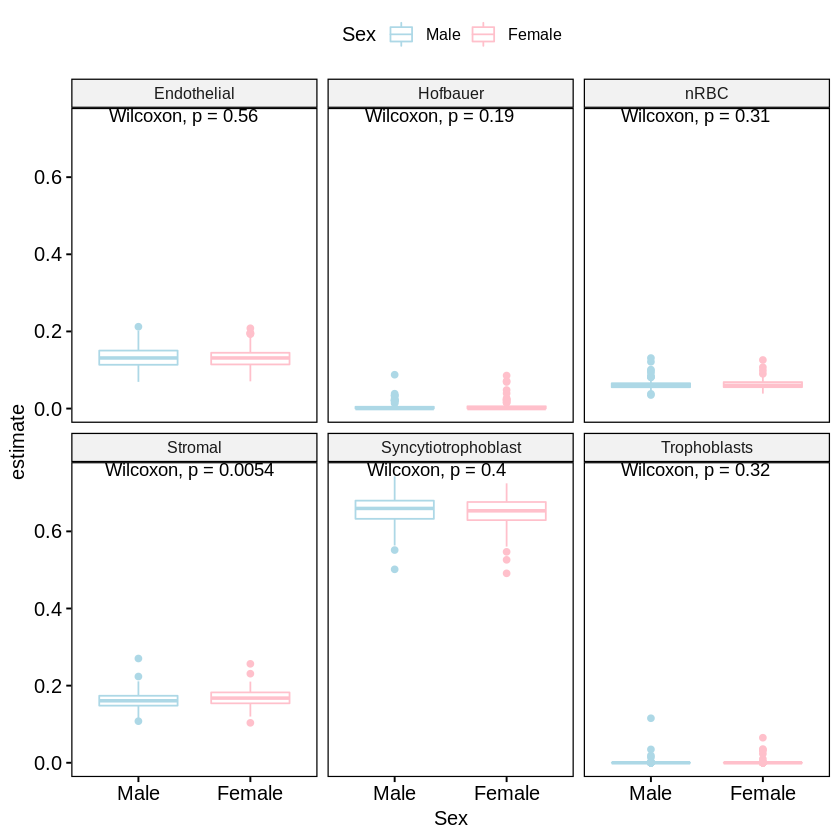

In [76]:
library(ggsignif)
library(ggpubr)
df <- cell_type_df %>% pivot_longer(cols = -c(sample,Sex),
             names_to = 'component',
             values_to = 'estimate') %>% 
        mutate(Sex = factor(Sex,levels = c("Male","Female")))
anno_df <- compare_means(estimate ~ Sex, group.by = "component", data = df) %>%
 mutate(y_pos = 1.0)
head(anno_df)
head(df)


ggboxplot(df,"Sex","estimate",facet.by = "component",color = "Sex",palette = c("light blue", "pink")) + 
    stat_compare_means()
# ggplot(df, aes(Sex,estimate)) + geom_boxplot() + facet_wrap(~component) +
#   geom_point(aes(color = Sex), position = position_jitterdodge()) + 
#   geom_signif(
#   data= anno_df,
#   aes(xmin = group1, xmax = group2, annotations = p.format, y_position = y_pos),
#   manual = TRUE) + coord_cartesian(ylim = c(0,1.1))

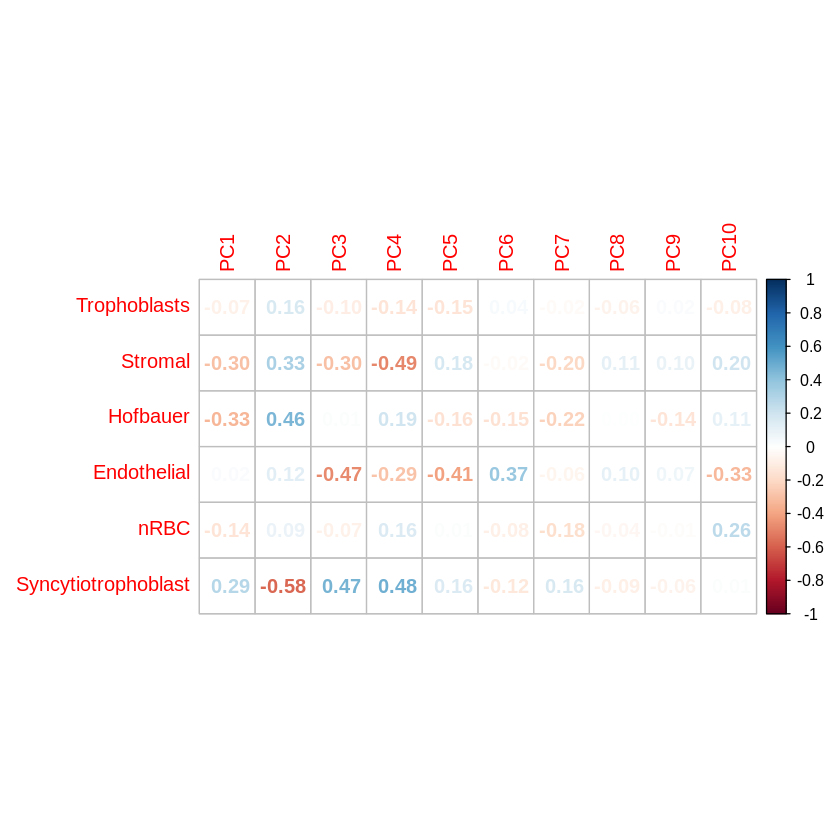

In [77]:
cor(cell_type_df %>% select(-sample,-Sex),metadata %>% select(contains("PC"))) %>% corrplot(method = "number")

# RICHS (Delahaye) Cohort
## Load in processed methylation data

In [68]:
metadata <- fread("/scratch/st-dennisjk-1/wcasazza/RICHS_QC/matrix_eqtl_data/mQTL_covar_10_methy_PC.txt")
varnames <-metadata$id
metadata <- t(metadata[,-c(1)]) %>% as.data.frame() %>% rownames_to_column("sample")
colnames(metadata)[-c(1)] <- varnames
head(metadata)
methy_data <- fread("/scratch/st-dennisjk-1/wcasazza/RICHS_QC/matrix_eqtl_data/methylation_matrixeQTL.txt") %>% column_to_rownames(var="cpg")
head(methy_data)

,sample,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,age,V3,V4,V5,V6,V7,Sex
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,S1,-23.384431,9.981986,-0.7103094,5.254825,-9.529762,1.900596,-6.092440,12.124606,-5.1201264,2.099208,39,-0.0459840,0.0292435,-0.03819540,-0.0922253,0.01778930,1
2,S2,5.018327,-10.779592,7.0836746,-5.566645,6.464558,-1.186355,1.370356,2.026148,-8.6807600,-2.511777,38,0.2572440,0.0577083,-0.02794240,0.0920946,0.05563260,0
3,S5,-23.114063,-4.049384,-7.0131103,7.607093,-4.549351,4.160800,-1.399341,2.472894,0.4684182,1.108868,39,-0.0479710,0.0296016,-0.01924480,0.0712592,-0.05974380,0
4,S6,-2.270164,-7.228691,2.1461517,-12.117418,1.129725,-3.821584,1.408548,-4.117444,7.4900930,-3.076262,37,-0.0446786,0.0220327,-0.00432461,-0.0130909,0.00297748,0
5,S7,3.115620,10.338543,-1.9751798,-9.847038,-2.557805,1.986721,5.891008,-5.738768,-0.6366907,2.626241,39,-0.0223935,-0.0499715,0.18993800,-0.0241225,-0.01589590,1
6,S9,-14.256361,7.127993,0.5840398,-2.171211,-3.521835,-2.482406,-2.509659,2.756437,0.8830981,-2.421768,38,-0.0439179,0.0163106,-0.01944180,-0.0133051,0.04197040,1


,GSM1947017,GSM1947018,GSM1947028,GSM1947046,GSM1947048,GSM1947089,GSM1947091,GSM1947099,GSM1947108,GSM1947117,⋯,GSM1947393,GSM1947396,GSM1947397,GSM1947400,GSM1947401,GSM1947402,GSM1947404,GSM1947405,GSM1947406,GSM1947408
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cg13869341,0.87762799,0.87304934,0.89744263,0.86843245,0.8210399,0.83455321,0.88577482,0.89658840,0.8563399,0.85957565,⋯,0.85033735,0.8610377,0.86236782,0.81435688,0.85700582,0.80674132,0.81311011,0.83950508,0.85718356,0.85300889
cg22802167,0.87440614,0.80363203,0.88697855,0.85777047,0.8772371,0.89081502,0.89184149,0.83969055,0.8530297,0.88543472,⋯,0.86668940,0.8855242,0.80905493,0.87444543,0.87916970,0.86853199,0.87797887,0.88369419,0.86876810,0.88089294
cg24669183,0.71733673,0.71722159,0.72319691,0.68720549,0.7621548,0.71285167,0.75455431,0.69913839,0.7614304,0.70628691,⋯,0.74362822,0.7779498,0.70365658,0.70860093,0.76605543,0.81013117,0.75087869,0.73262768,0.75499413,0.82401442
cg15560884,0.65435039,0.57248285,0.74344898,0.62250912,0.6157954,0.69190976,0.73679387,0.66162878,0.6817297,0.71061106,⋯,0.56768432,0.6007239,0.54788993,0.58455525,0.59731987,0.58963532,0.57635452,0.55851557,0.57478242,0.60009925
cg01014490,0.09136668,0.06479905,0.04121286,0.04485541,0.0789296,0.09154261,0.06534519,0.06075887,0.0299858,0.02426678,⋯,0.04856043,0.0495760,0.06636181,0.06554436,0.08280511,0.06114293,0.04537315,0.09653715,0.03955144,0.05197615
cg17505339,0.85782615,0.88035049,0.87141489,0.89801967,0.8883472,0.89744514,0.90017484,0.88787161,0.8895833,0.91918624,⋯,0.90397609,0.8825137,0.84914078,0.89208043,0.89703476,0.89874800,0.88278891,0.87603926,0.85244427,0.94693461


## Cell type estimation

In [69]:
data('plCellCpGsThird')
houseman_estimates <- minfi:::projectCellType(
  methy_data[rownames(plCellCpGsThird),], 
  plCellCpGsThird,
  lessThanOne = FALSE)
houseman_estimates %>% write.csv(file = "../data/houseman_placenta_cell_type_prop.csv",row.names = F, quote=F)

## Plot out proportions

sample,Sex,component,estimate
<fct>,<chr>,<chr>,<dbl>
GSM1947017,Male,Trophoblasts,0.00000000
GSM1947017,Male,Stromal,0.19040019
GSM1947017,Male,Hofbauer,0.02532785
GSM1947017,Male,Endothelial,0.15008707
GSM1947017,Male,nRBC,0.05925774
GSM1947017,Male,Syncytiotrophoblast,0.59928035


Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


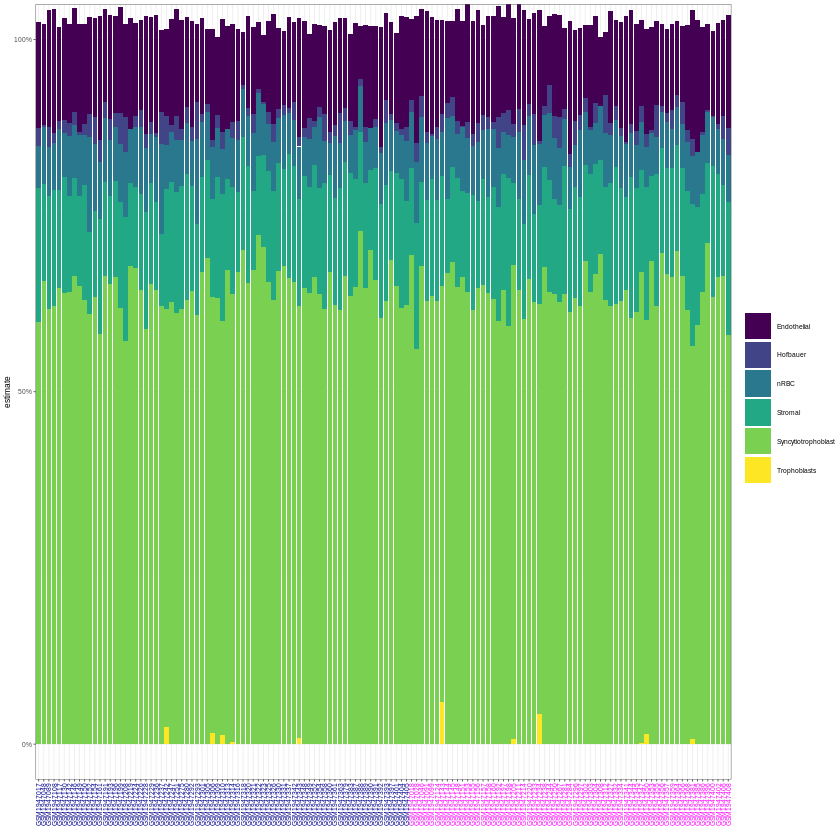

In [70]:
cell_type_df <- houseman_estimates  %>% as_tibble() %>% mutate(sample = colnames(methy_data),Sex = metadata$Sex) %>% 
            mutate(Sex = ifelse(Sex == 1, "Male","Female"))
                                                                 
plot_df <- cell_type_df %>% pivot_longer(cols = -c(sample,Sex),
             names_to = 'component',
             values_to = 'estimate') 
plot_df$sample <- factor(plot_df$sample, levels = c(unique(plot_df$sample[plot_df$Sex == "Male"]), unique(plot_df$sample[plot_df$Sex == "Female" ])))
head(plot_df)
color_map <- data.frame(sample = levels(plot_df$sample)) %>% mutate(color = ifelse(sample %in% cell_type_df$sample[cell_type_df$Sex == "Male"],"darkblue","magenta"))


  ggplot(plot_df, aes(x = sample, y = estimate, fill = component)) +
  geom_bar(stat = 'identity') +
  scale_fill_viridis_d() +
  theme_bw(base_size = 5) +
  scale_y_continuous(limits = c(-0.1,1.1), breaks = c(0, 0.5, 1), labels = scales::percent) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, color = color_map$color)) +
  coord_cartesian(ylim = c(0,1)) +
  labs(x = '', fill = '')

## Sex differences in proportions

component,.y.,group1,group2,p,p.adj,p.format,p.signif,method,y_pos
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Trophoblasts,estimate,Male,Female,0.2288011,1,0.23,ns,Wilcoxon,1
Stromal,estimate,Male,Female,0.7171850,1,0.72,ns,Wilcoxon,1
Hofbauer,estimate,Male,Female,0.3791928,1,0.38,ns,Wilcoxon,1
Endothelial,estimate,Male,Female,0.5974571,1,0.60,ns,Wilcoxon,1
nRBC,estimate,Male,Female,0.7335531,1,0.73,ns,Wilcoxon,1
Syncytiotrophoblast,estimate,Male,Female,0.5734526,1,0.57,ns,Wilcoxon,1


sample,Sex,component,estimate
<chr>,<fct>,<chr>,<dbl>
GSM1947017,Male,Trophoblasts,0.00000000
GSM1947017,Male,Stromal,0.19040019
GSM1947017,Male,Hofbauer,0.02532785
GSM1947017,Male,Endothelial,0.15008707
GSM1947017,Male,nRBC,0.05925774
GSM1947017,Male,Syncytiotrophoblast,0.59928035


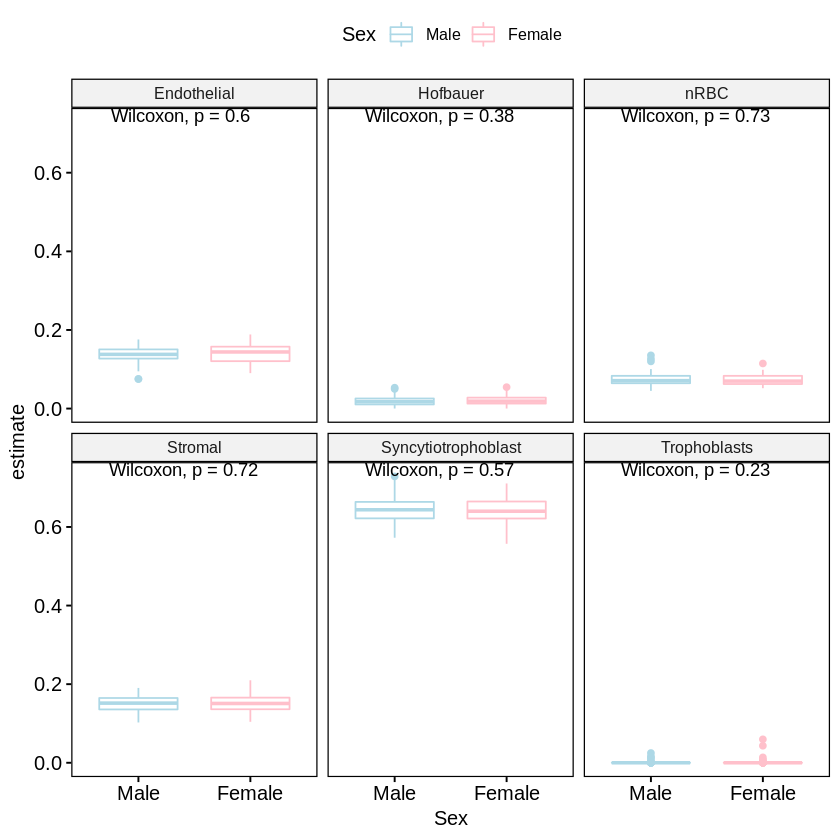

In [71]:
library(ggsignif)
library(ggpubr)
df <- cell_type_df %>% pivot_longer(cols = -c(sample,Sex),
             names_to = 'component',
             values_to = 'estimate') %>% 
        mutate(Sex = factor(Sex,levels = c("Male","Female")))
anno_df <- compare_means(estimate ~ Sex, group.by = "component", data = df) %>%
 mutate(y_pos = 1.0)
head(anno_df)
head(df)


ggboxplot(df,"Sex","estimate",facet.by = "component",color = "Sex",palette = c("light blue", "pink")) + 
    stat_compare_means()
# ggplot(df, aes(Sex,estimate)) + geom_boxplot() + facet_wrap(~component) +
#   geom_point(aes(color = Sex), position = position_jitterdodge()) + 
#   geom_signif(
#   data= anno_df,
#   aes(xmin = group1, xmax = group2, annotations = p.format, y_position = y_pos),
#   manual = TRUE) + coord_cartesian(ylim = c(0,1.1))

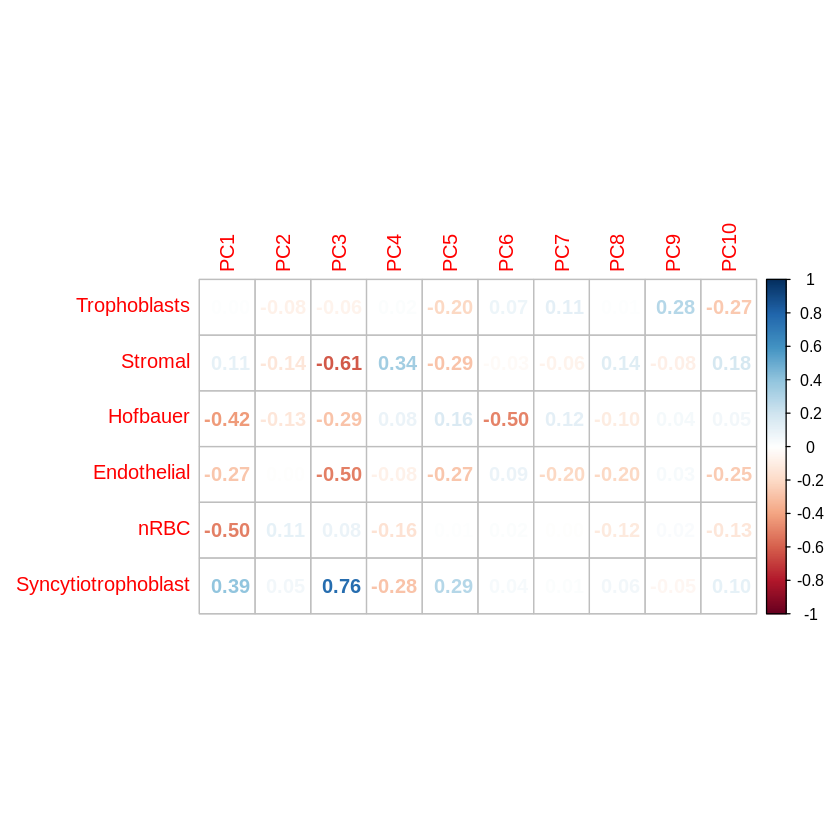

In [72]:
cor(cell_type_df %>% select(-sample,-Sex),metadata %>% select(contains("PC"))) %>% corrplot(method = "number")